In [55]:
import pandas as pd
from collections import Counter
import random as rnd
import numpy as np
import sklearn.ensemble as sk
import sklearn.metrics as skm
import matplotlib.pyplot as plt
%matplotlib inline

In [37]:
df = pd.read_csv("./data/samraw.csv")

def cleanUp(s):
    s = s.replace("Body", "")
    s = s.replace("Mag", "")
    s = s.replace("-std", "SD")
    s = s.replace("-mean", "Mean")
    s = s.replace("-skewness", "Skewness")
    s = s.replace("-kurtosis", "Kurtosis")
    s = s.replace("(","")
    s = s.replace(")","")
    s = s.replace("anglet", "angle")
    s = s.replace(",gravity", "Gravity")
    return s

df.rename(columns=lambda x: cleanUp(x), inplace= True)
#df.drop([])


def dropColumns(x):
    if x.find("X") != -1 or x.find("Y") != -1 or x.find("Z") != -1:
        return False
    if x.count("max") != 0 or x.count("min") != 0 or x.count("mad") != 0 or x.count("sma") != 0:
        return False
    if x.count("band"):
        return False
    if x.count("entropy") != 0 or x.count("arCoeff") or x.count("energy") or x.count("iqr"):
        return False
    return True

#Remaping de actividades
def remap_col(df, colname):
    map_dict = {'laying':1, 'sitting':2, 'standing':3, 'walk':4, 'walkup':5, 'walkdown':6} 
    df[colname] = df[colname].map(lambda x: map_dict[x]) 
    return df

df = remap_col(df, "activity")

data = df[df.columns[df.columns.map(dropColumns)]]

In [45]:
g = data.groupby(by="subject")
#train = pd.concat(list(g)[-4:][1])


N = len(g) - 4 #le saco los 4 primeros a los grupos
n = int(np.ceil(N * 0.7)) #Obtengo el 70% de N, para después sacar esa cantidad de grupos

for i in range(n):
    lst.append(list(g)[i][1])
train = pd.concat(lst)

lst = []
for i in range(N-n):
    lst.append(list(g)[i][1])
val = pd.concat(lst)

#Metadata: usar los 4 últimos sujetos como testeo
test = pd.concat(list(map( lambda x: x[1], list(g)[-4:])))

#test = pd.read_csv("./data/samtest.csv")

#val = pd.read_csv("./data/samval.csv")
#train = pd.read_csv("./data/samtrain.csv")

#test = remap_col(test, "activity")
#val = remap_col(val, "activity")
#train = remap_col(train, "activity")

In [46]:
rfc = sk.RandomForestClassifier(n_estimators=500, oob_score=True)

train_data = train[train.columns[1:-2]]
train_truth = train['activity']
model = rfc.fit(train_data, train_truth)

C:\Users\sadeus\Anaconda3\lib\site-packages\sklearn\base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
C:\Users\sadeus\Anaconda3\lib\site-packages\sklearn\base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
C:\Users\sadeus\Anaconda3\lib\site-packages\sklearn\base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
C:\Users\sadeus\Anaconda3\lib\site-packages\sklearn\base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
C:\Users\sadeus\Anaconda3\lib\site-packages\sklearn\base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, var

In [47]:
rfc.oob_score_

0.92485943090816147

In [49]:
fi = enumerate(rfc.feature_importances_)
cols = train.columns
[(value,cols[i]) for (i,value) in fi if value > 0.04]

[(0.057150539092680794, 'tAccMean'),
 (0.050024054046500302, 'tGravityAccMean'),
 (0.053388542479544478, 'tGravityAccSD'),
 (0.047695596971640837, 'tAccJerkMean'),
 (0.040896958714200529, 'tGyroSD'),
 (0.050256159200295962, 'tGyroJerkSD'),
 (0.050789312081235542, 'fAccMean'),
 (0.054749923269765362, 'fAccKurtosis'),
 (0.051642162574301313, 'fAccJerkMean')]

In [60]:
val_data = val[val.columns[1:-2]]
val_truth = val['activity']
val_pred = rfc.predict(val_data)

test_data = test[test.columns[1:-2]]
test_truth = test['activity']
test_pred = rfc.predict(test_data)

print("mean accuracy score for validation set = %f" %(rfc.score(val_data, val_truth)))
print("mean accuracy score for test set = %f" %(rfc.score(test_data, test_truth)))

mean accuracy score for validation set = 1.000000
mean accuracy score for test set = 0.739394


C:\Users\sadeus\Anaconda3\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


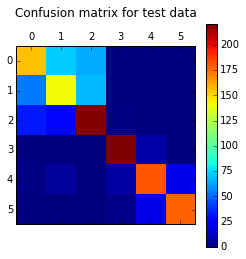

In [59]:
test_cm = skm.confusion_matrix(test_truth,test_pred)

plt.matshow(test_cm)
plt.title('Confusion matrix for test data\n')
plt.colorbar()

In [61]:
# Accuracy
print("Accuracy = %f" %(skm.accuracy_score(test_truth,test_pred)))

# Precision
print("Precision = %f" %(skm.precision_score(test_truth,test_pred)))

# Recall
print("Recall = %f" %(skm.recall_score(test_truth,test_pred)))

# F1 Score
print("F1 score = %f" %(skm.f1_score(test_truth,test_pred)))

Accuracy = 0.739394
Precision = 0.740269
Recall = 0.739394
F1 score = 0.737131


C:\Users\sadeus\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1082: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
C:\Users\sadeus\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1172: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_we